In [1]:
import os
import sys
sys.path.append(os.getcwd() + '/../../')
print('\n'.join(list(filter(lambda x: 'AutoQuant' in x, map(str, sys.path)))))

/Users/xian/Documents/codes/AutoQuant/examples/zh-cn
/Users/xian/Documents/codes/AutoQuant/examples/zh-cn/../../


In [2]:
from autoquant.provider.tushare import TushareProvider
from autoquant.collector import Collector
from autoquant.provider.baostock import BaostockProvider
from autoquant.provider.eastmoney import EastmoneyProvider
from autoquant import Market, FundsIndex
from datetime import date

[2023-02-02 15:17:02] [10162:8608224768] [DEBUG] [autoquant.log] log.py:<module>:32 AutoQuant logs will be printed in console
2023-02-02 15:17:02,352 - autoquant.log - DEBUG - AutoQuant logs will be printed in console


# 获取数据

In [3]:
collector = Collector().with_price_provider(EastmoneyProvider()).with_index_provider(EastmoneyProvider())

In [4]:
#data = collector.funds_of_index(index=FundsIndex.CN_ETF, details=True)
#data

In [5]:
#data.to_csv('CN_ETF.funds.csv', index=False, header=True)

# 数据处理

In [6]:
import pandas as pd
df = pd.read_csv('CN_ETF.funds.csv', converters={'code': str})
df

,updated_at,market,code,name,company,manager,created_at,share,type,benchmark,tracking
0,2023-01-30,Market.CN,000008,嘉实中证500ETF联接A,嘉实基金,何如、李直,2013-03-22,2.929,指数型-股票,中证500指数收益率*95% + 银行活期存款税后利率*5%,中证500指数
1,2023-01-30,Market.CN,000051,华夏沪深300ETF联接A,华夏基金,张弘弢、赵宗庭,2009-07-10,247.720,指数型-股票,"沪深300指数收益率*95%+1%(指年收益率,评价时应按期间折算)",沪深300指数
2,2023-01-30,Market.CN,000055,广发纳指100ETF联接美元(QDII)A,广发基金,刘杰,2015-01-16,--,QDII,人民币计价的纳斯达克100总收益指数收益率,该基金无跟踪标的
3,2023-01-30,Market.CN,000071,华夏恒生ETF联接A,华夏基金,徐猛,2012-08-21,8.547,QDII,经人民币汇率调整的恒生指数收益率×95% +人民币活期存款税后利率×5%,香港恒生指数
4,2023-01-30,Market.CN,000075,华夏恒生ETF联接现汇,华夏基金,徐猛,2012-08-21,8.547,QDII,经人民币汇率调整的恒生指数收益率×95% +人民币活期存款税后利率×5%,香港恒生指数
...,...,...,...,...,...,...,...,...,...,...,...
696,2023-01-30,Market.CN,519032,海富通上证非周期ETF联接,海富通基金,江勇,2011-04-27,3.808,指数型-股票,上证非周期行业100指数收益率×95%+活期存款利率(税后)×5%,非周期
697,2023-01-30,Market.CN,530010,建信上证社会责任ETF联接,建信基金,薛玲,2010-05-28,23.965,指数型-股票,95%×上证社会责任指数收益率+5%×商业银行税后活期存款利率,责任指数
698,2023-01-30,Market.CN,530015,建信深证基本面60ETF联接A,建信基金,薛玲,2011-09-08,9.282,指数型-股票,95%×深证基本面60指数收益率+5%×商业银行活期存款利率,深证基本面60指数
699,2023-01-30,Market.CN,560860,万家中证工业有色金属主题ETF,万家基金,杨坤,NaN,--,指数型-股票,标的指数收益率,中证工业有色金属主题指数


In [7]:
tracking = df['tracking'].unique().tolist()

# 计算同一跟踪目标不同基金的相关性
> 目的：试图判断是否存在违严格跟踪目标的基金

In [8]:
import arrow
from pathlib import Path

today = arrow.get('2023/01/30').date()
for _, g in df.groupby('tracking'):
    target = g['tracking'].tolist()[0]
    for _, row in g.iterrows():
        if pd.isnull(row['created_at']):
            print(f'ignore {row["code"]}: {row["name"]} {row["created_at"]}')
            break
        
        fname = f'.output.{row["code"]}.{row["created_at"]}_{today.strftime("%Y-%m-%d")}.csv'
        if not Path(fname).exists():
            data = collector.daily_prices(market=Market.CN, code=row['code'], start=arrow.get(row['created_at']).date(), end=today)
            data.to_csv(fname)


ignore 159678: 博时中证500增强策略ETF nan
ignore 560860: 万家中证工业有色金属主题ETF nan
ignore 016007: 招商中证消费电子主题ETF联接A nan
ignore 513560: 兴银中证港股通科技ETF nan
ignore 159671: 工银瑞信中证稀有金属主题ETF nan
ignore 016357: 易方达中证长江保护主题ETF联接发起式A nan
ignore 159653: 国联安国证ESG300ETF nan
ignore 159657: 鹏华国证疫苗与生物科技ETF nan
ignore 513650: 南方标普500ETF(QDII) nan
ignore 016581: 嘉实上海金ETF发起联接A nan


In [132]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def corr_plot(d, title):
    sns.set_theme(style="white")

    # Compute the correlation matrix
    corr = d.corr()
    
    # Generate a custom diverging colormap
    cmap = sns.color_palette("Spectral_r", as_cmap=True)


    # Draw the heatmap with the mask and correct aspect ratio
    plt.rcParams['font.sans-serif'] = ["Heiti TC"]  # 指定默认字体
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
    
    plt.figure(figsize=(d.shape[1] * 1.3, d.shape[1] * 1.2))
    plt.title(title, fontsize=16, fontweight="bold")
    
    sns.heatmap(corr,  cmap=cmap, fmt=".2f",annot=True, linewidths=.1, vmin=corr.min()[1]/2, vmax=1.1)
    plt.show()


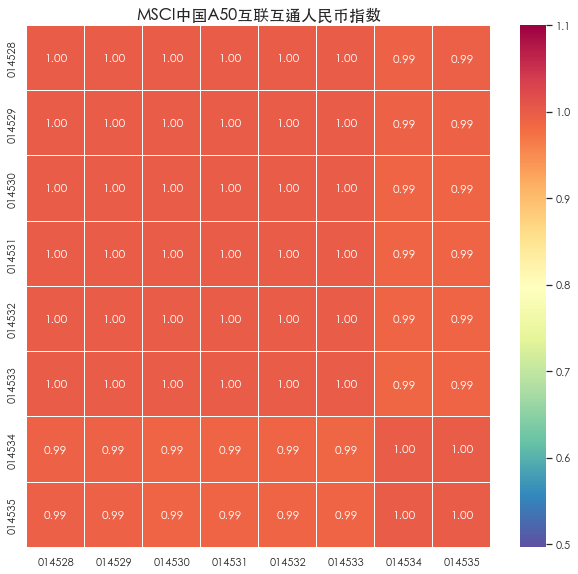

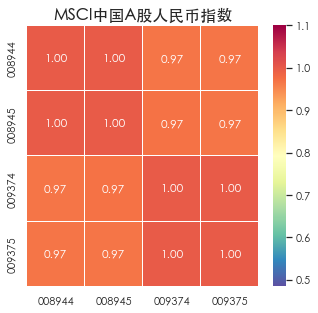

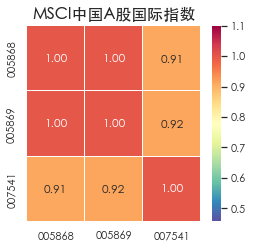

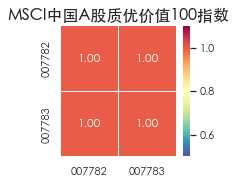

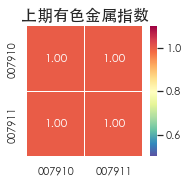

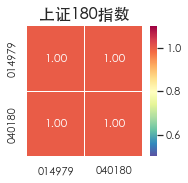

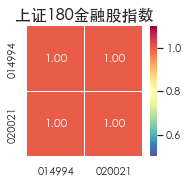

ignore group cause no valid data: 上证380


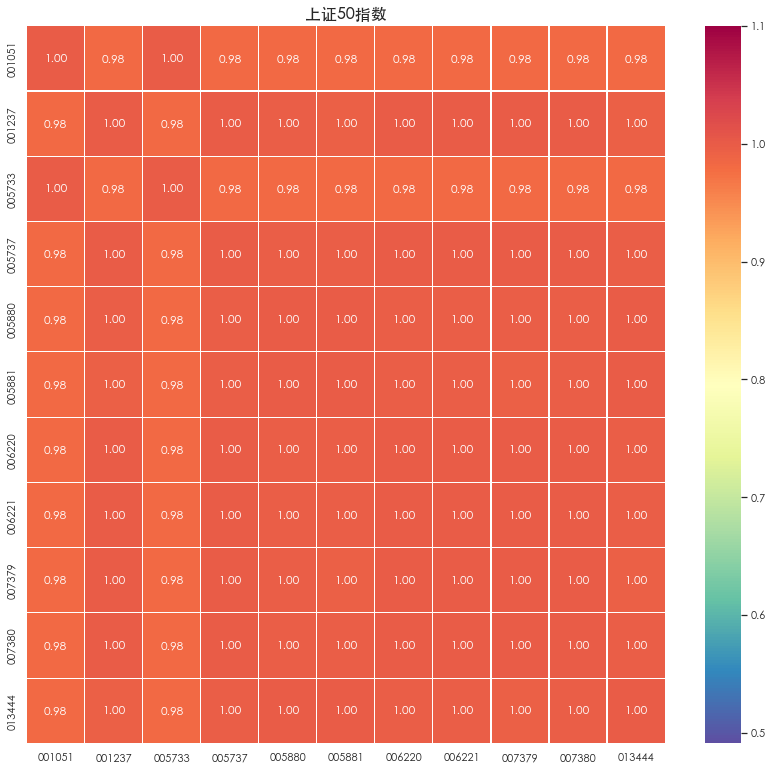

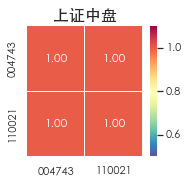

ignore group cause no valid data: 上证周期


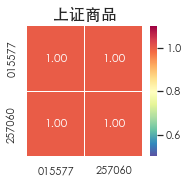

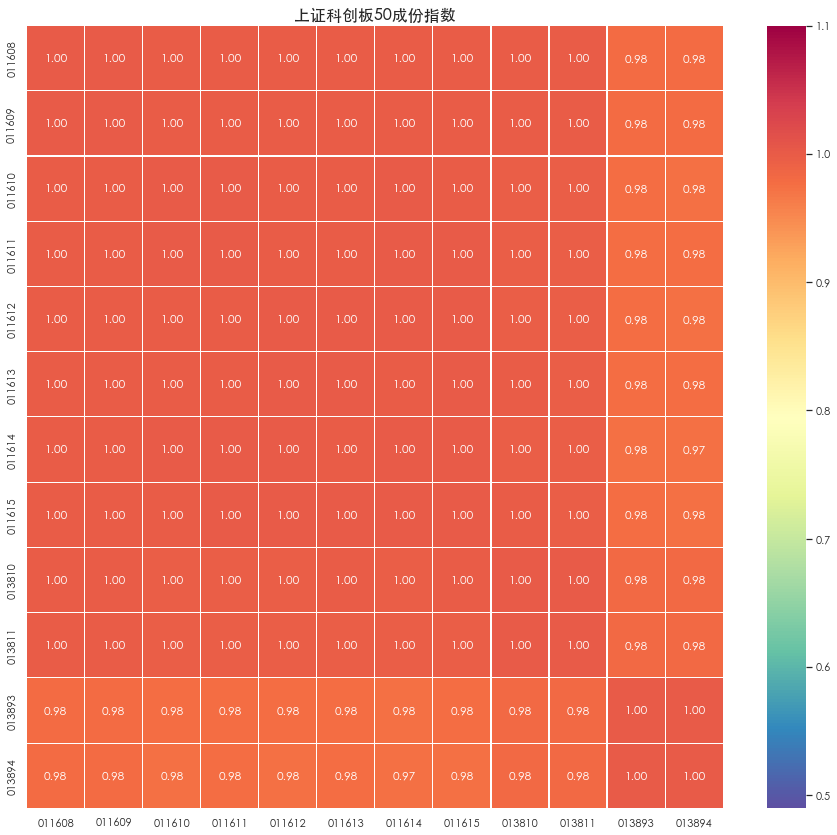

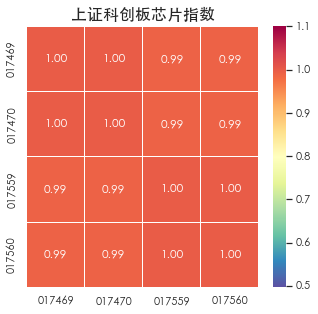

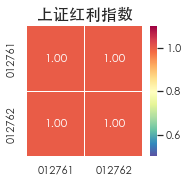

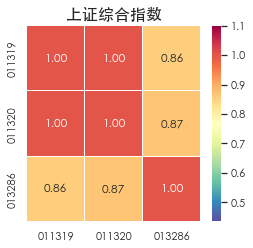

ignore group cause no valid data: 上证资源
ignore group cause no valid data: 上证超级大盘指数


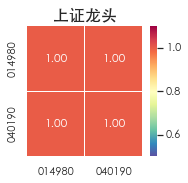

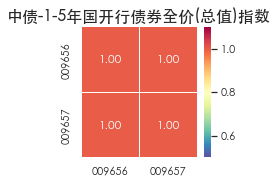

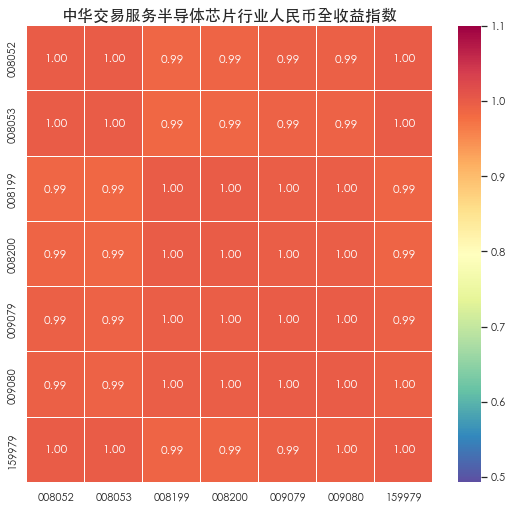

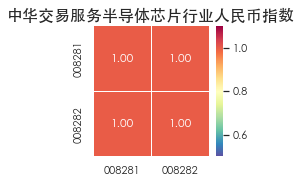

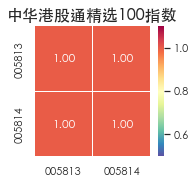

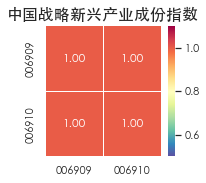

ignore group cause no valid data: 中小企业300指数


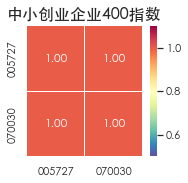

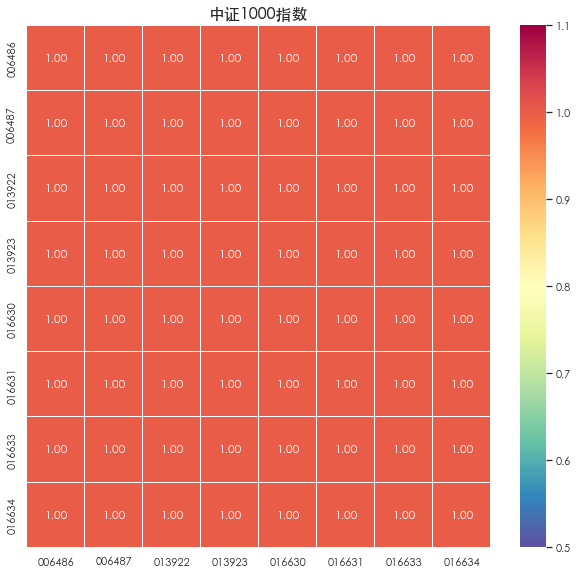

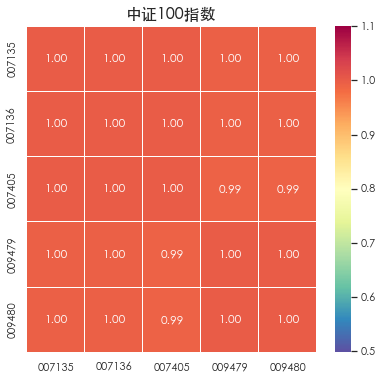

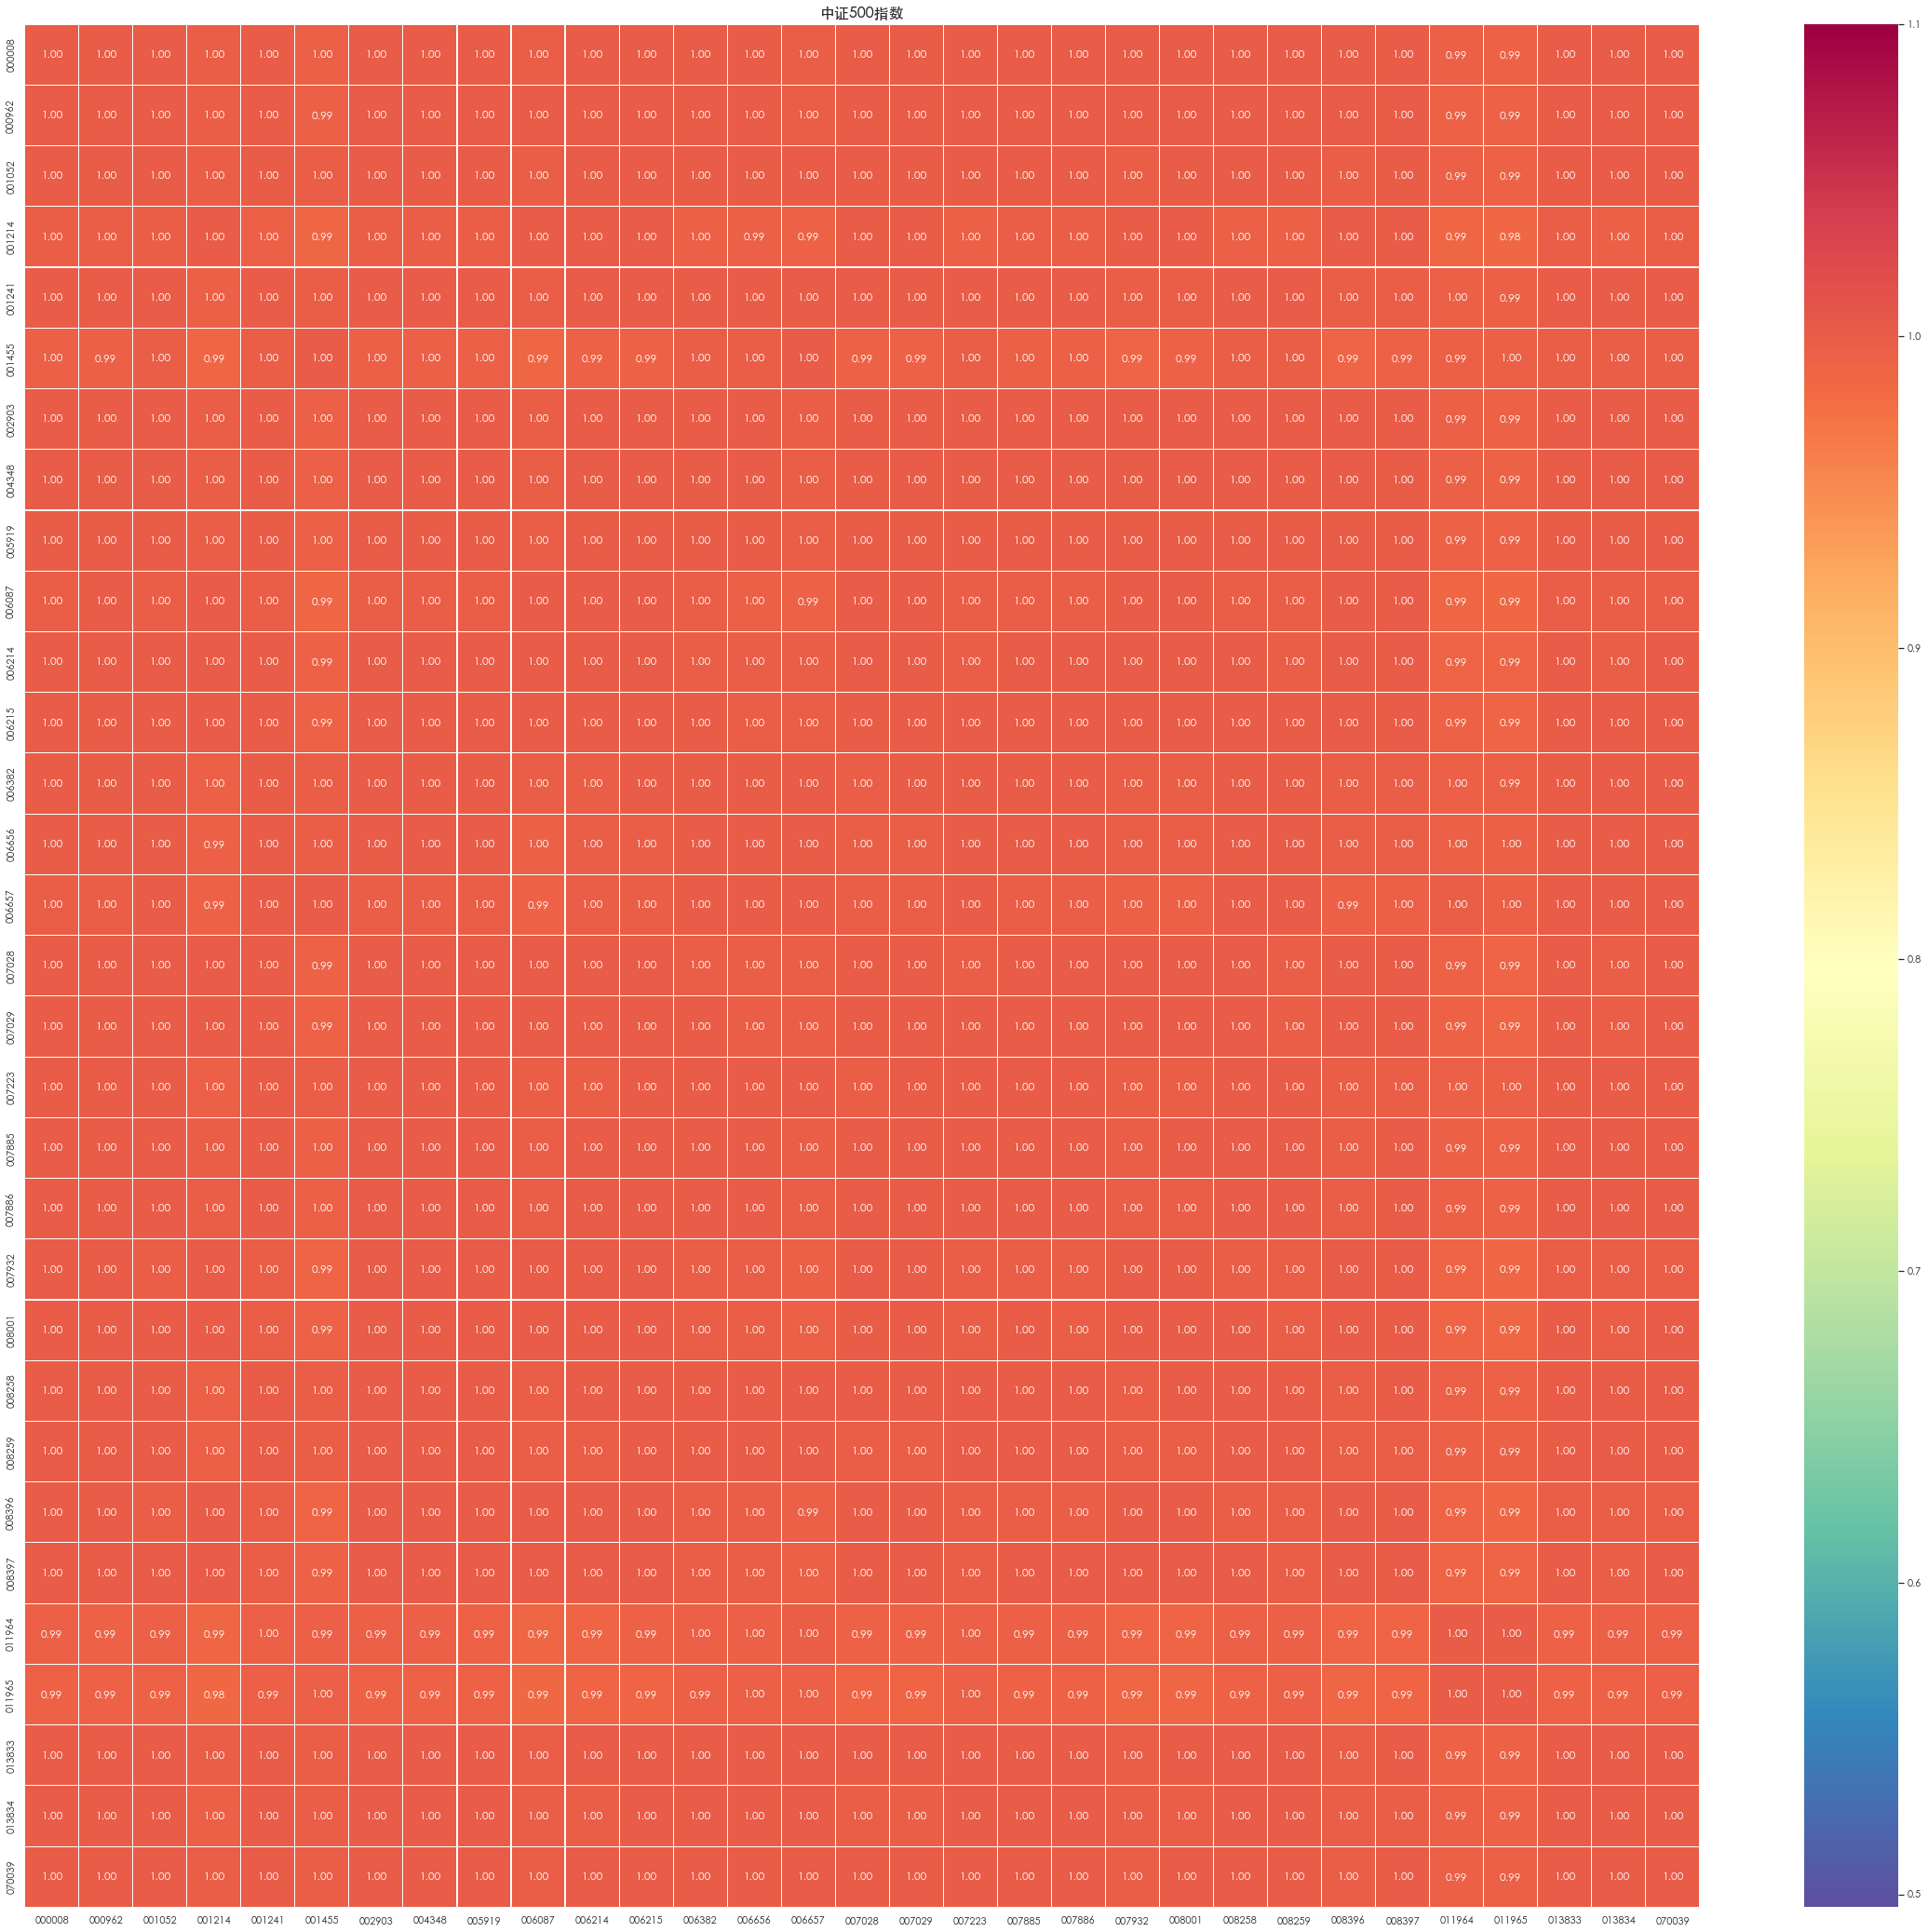

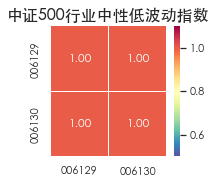

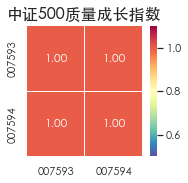

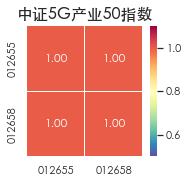

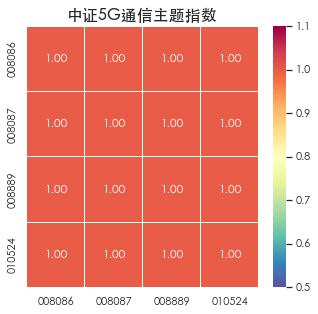

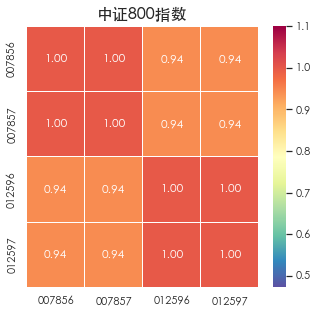

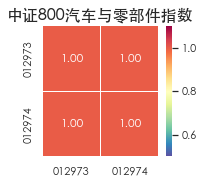

ignore group cause no valid data: 中证上海国企指数


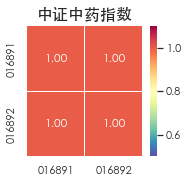

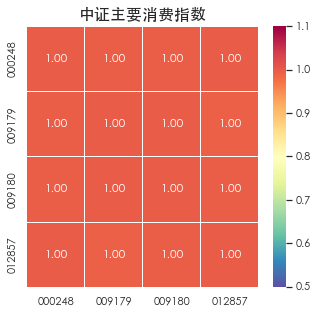

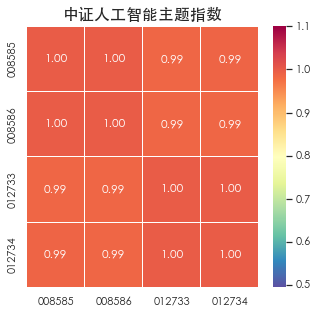

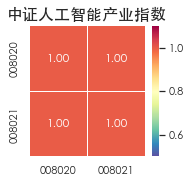

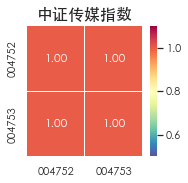

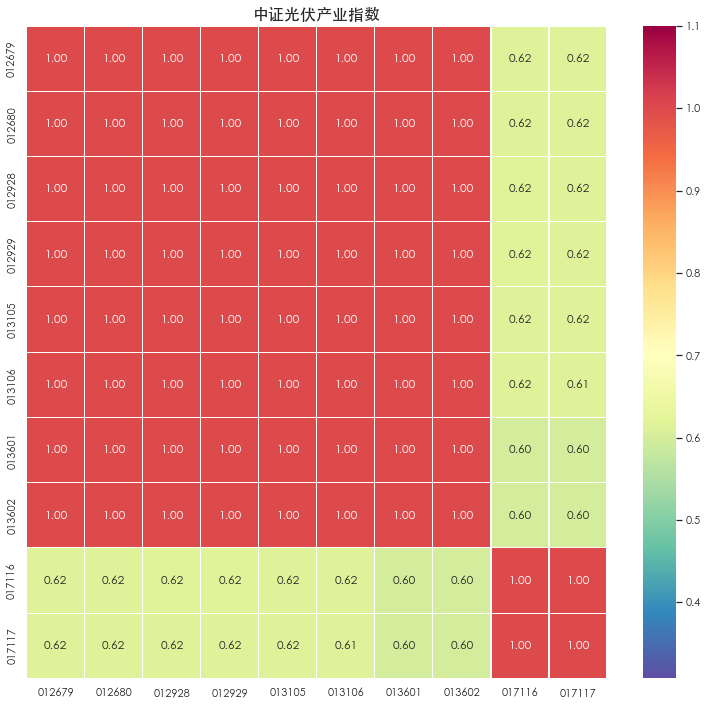

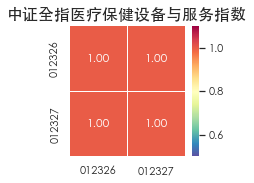

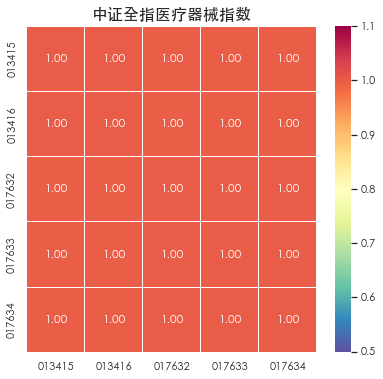

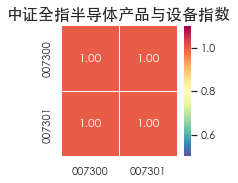

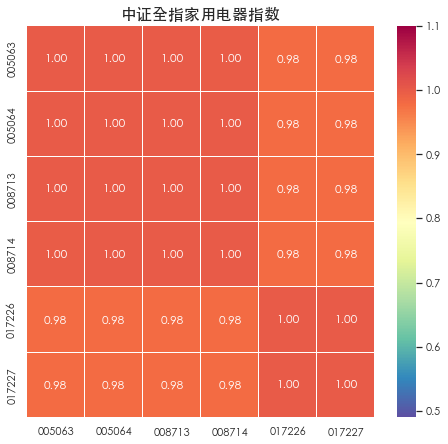

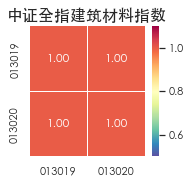

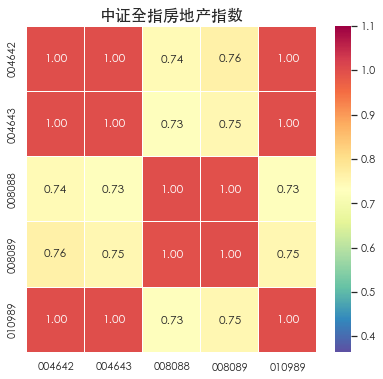

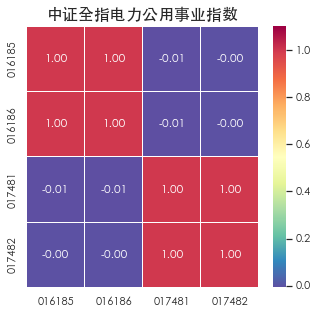

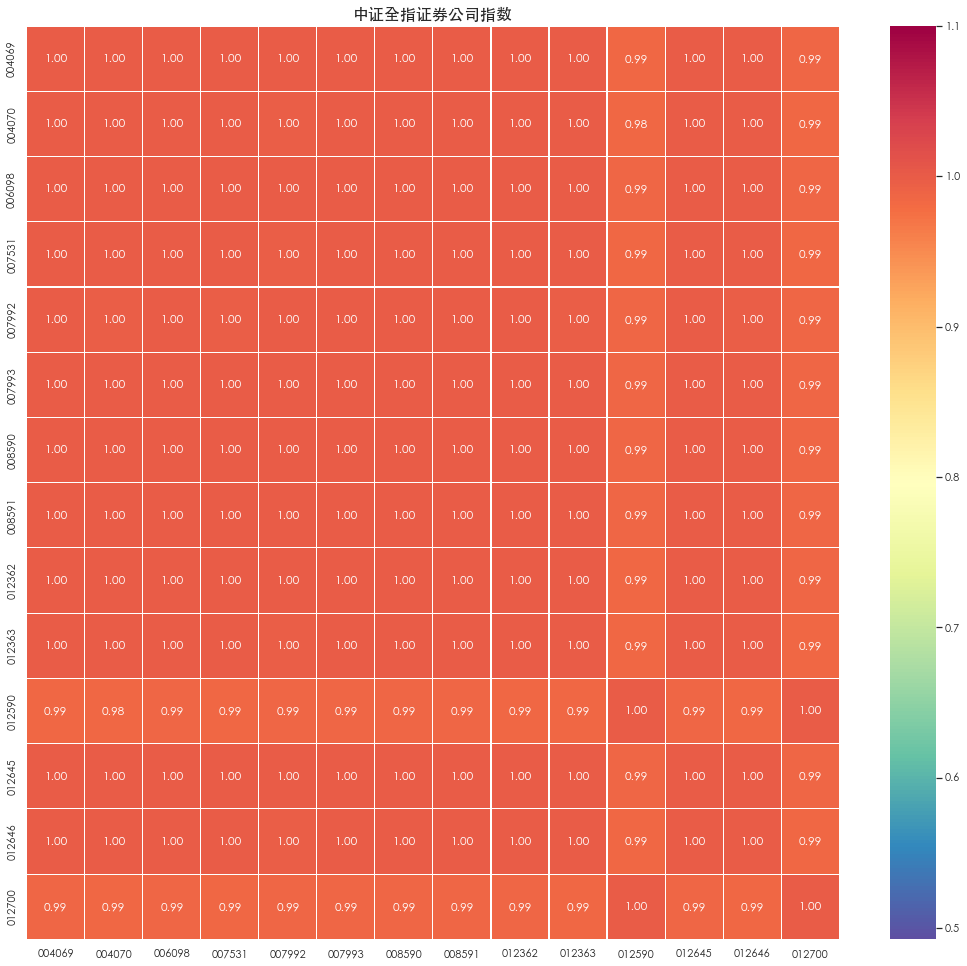

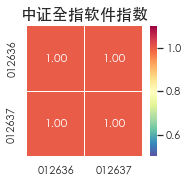

ignore group cause no valid data: 中证全指运输指数


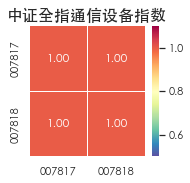

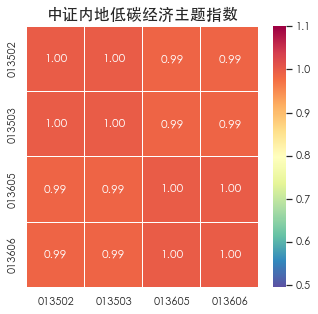

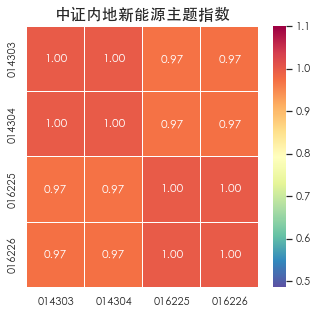

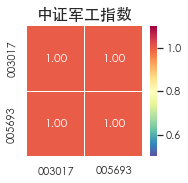

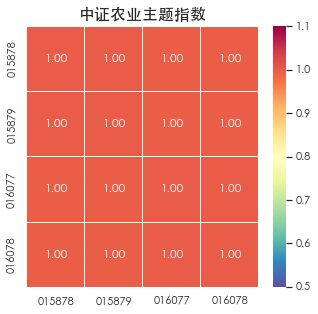

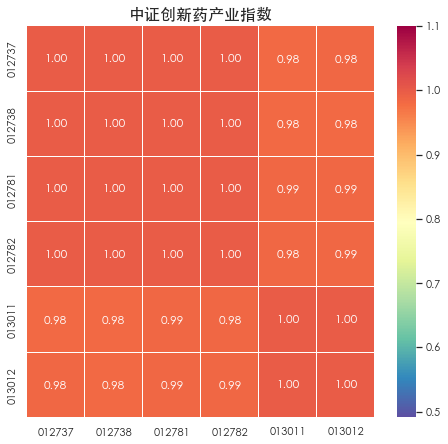

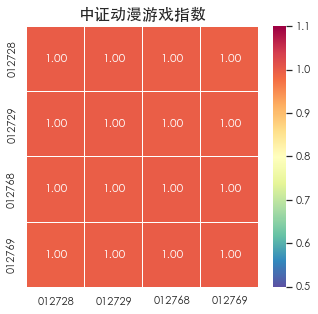

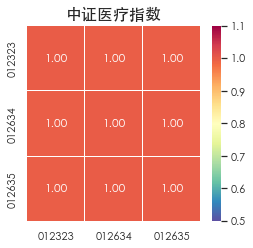

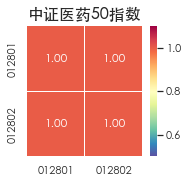

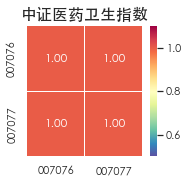

ignore group cause no valid data: 中证南方小康产业指数


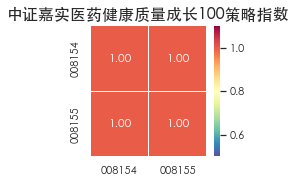

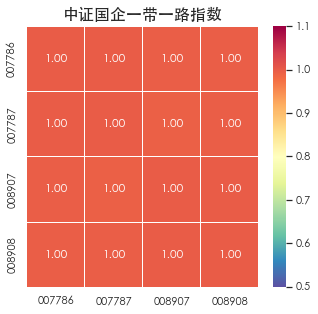

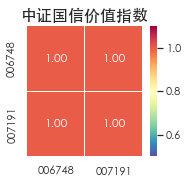

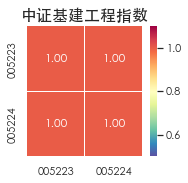

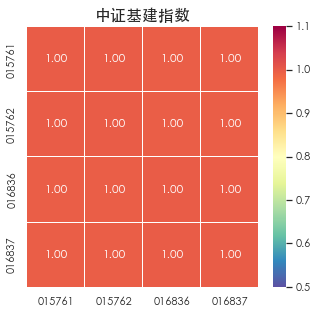

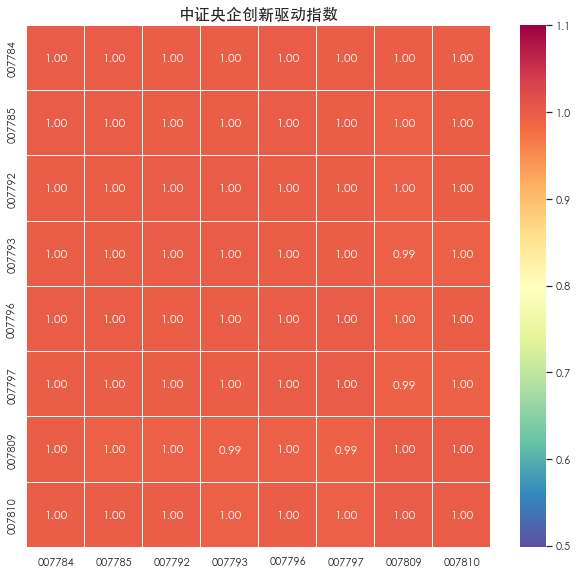

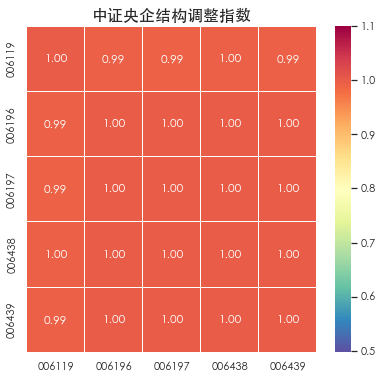

ignore group cause no valid data: 中证工业有色金属主题指数


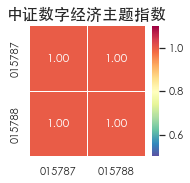

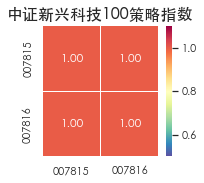

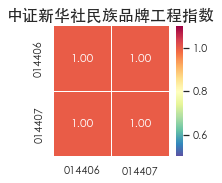

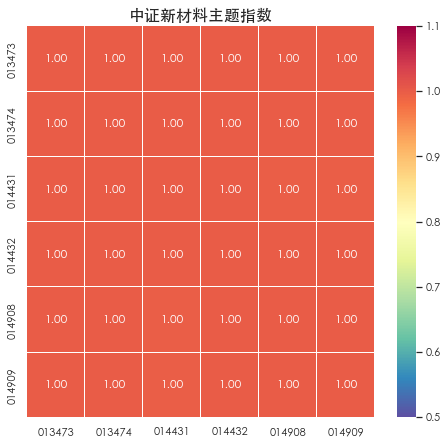

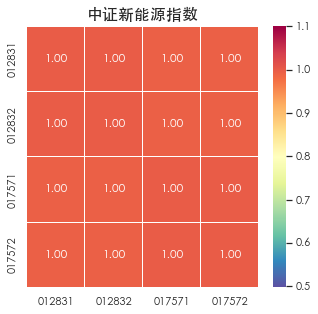

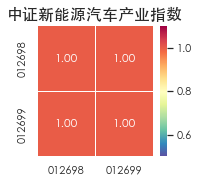

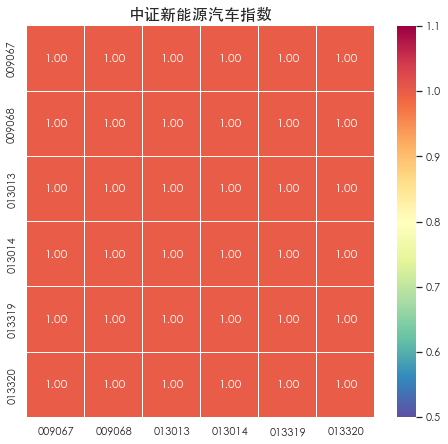

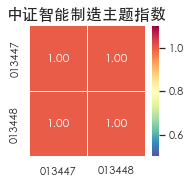

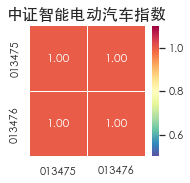

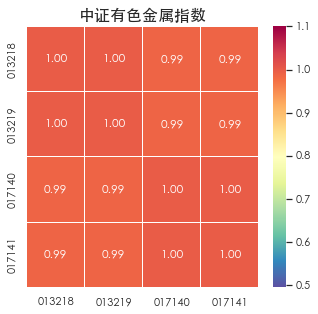

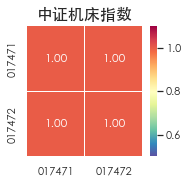

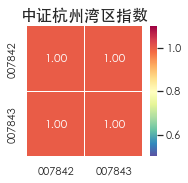

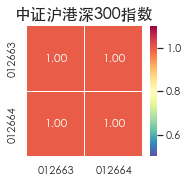

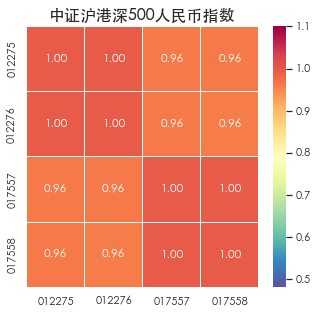

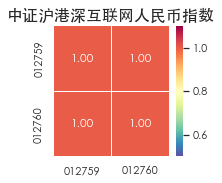

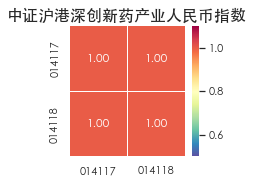

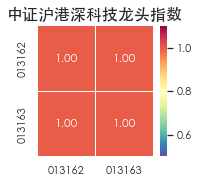

ignore group cause no valid data: 中证沪港深粤港澳大湾区发展主题人民币指数


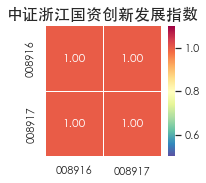

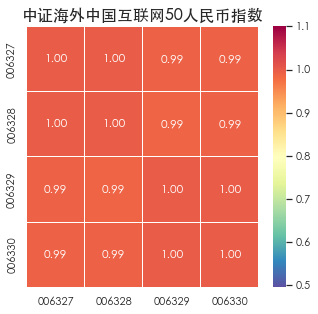

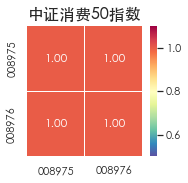

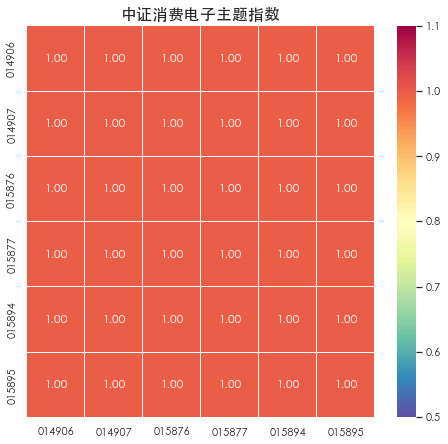

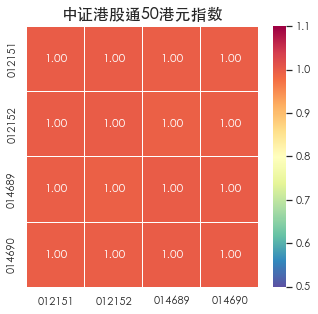

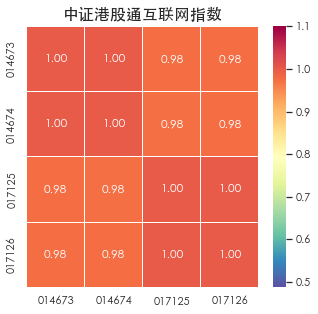

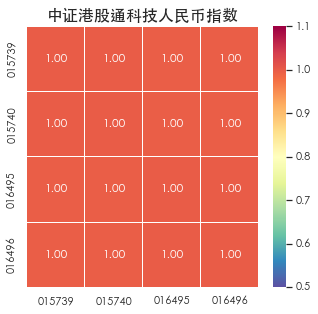

ignore group cause no valid data: 中证港股通科技港币指数


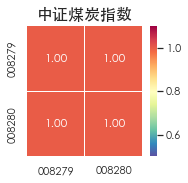

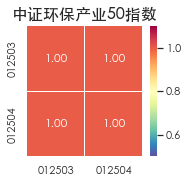

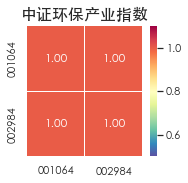

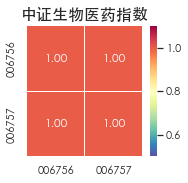

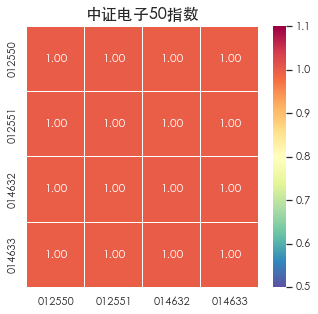

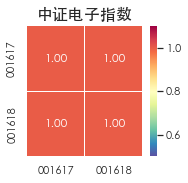

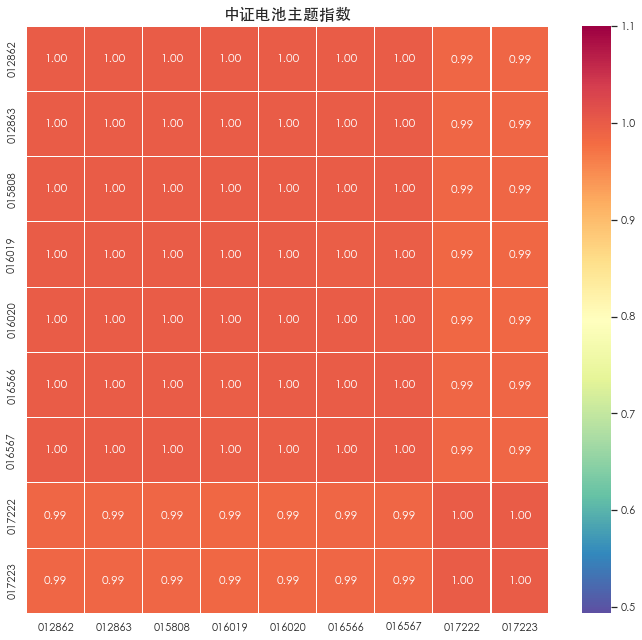

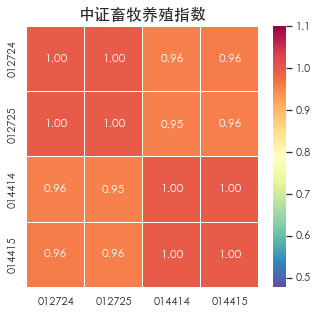

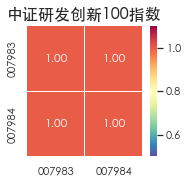

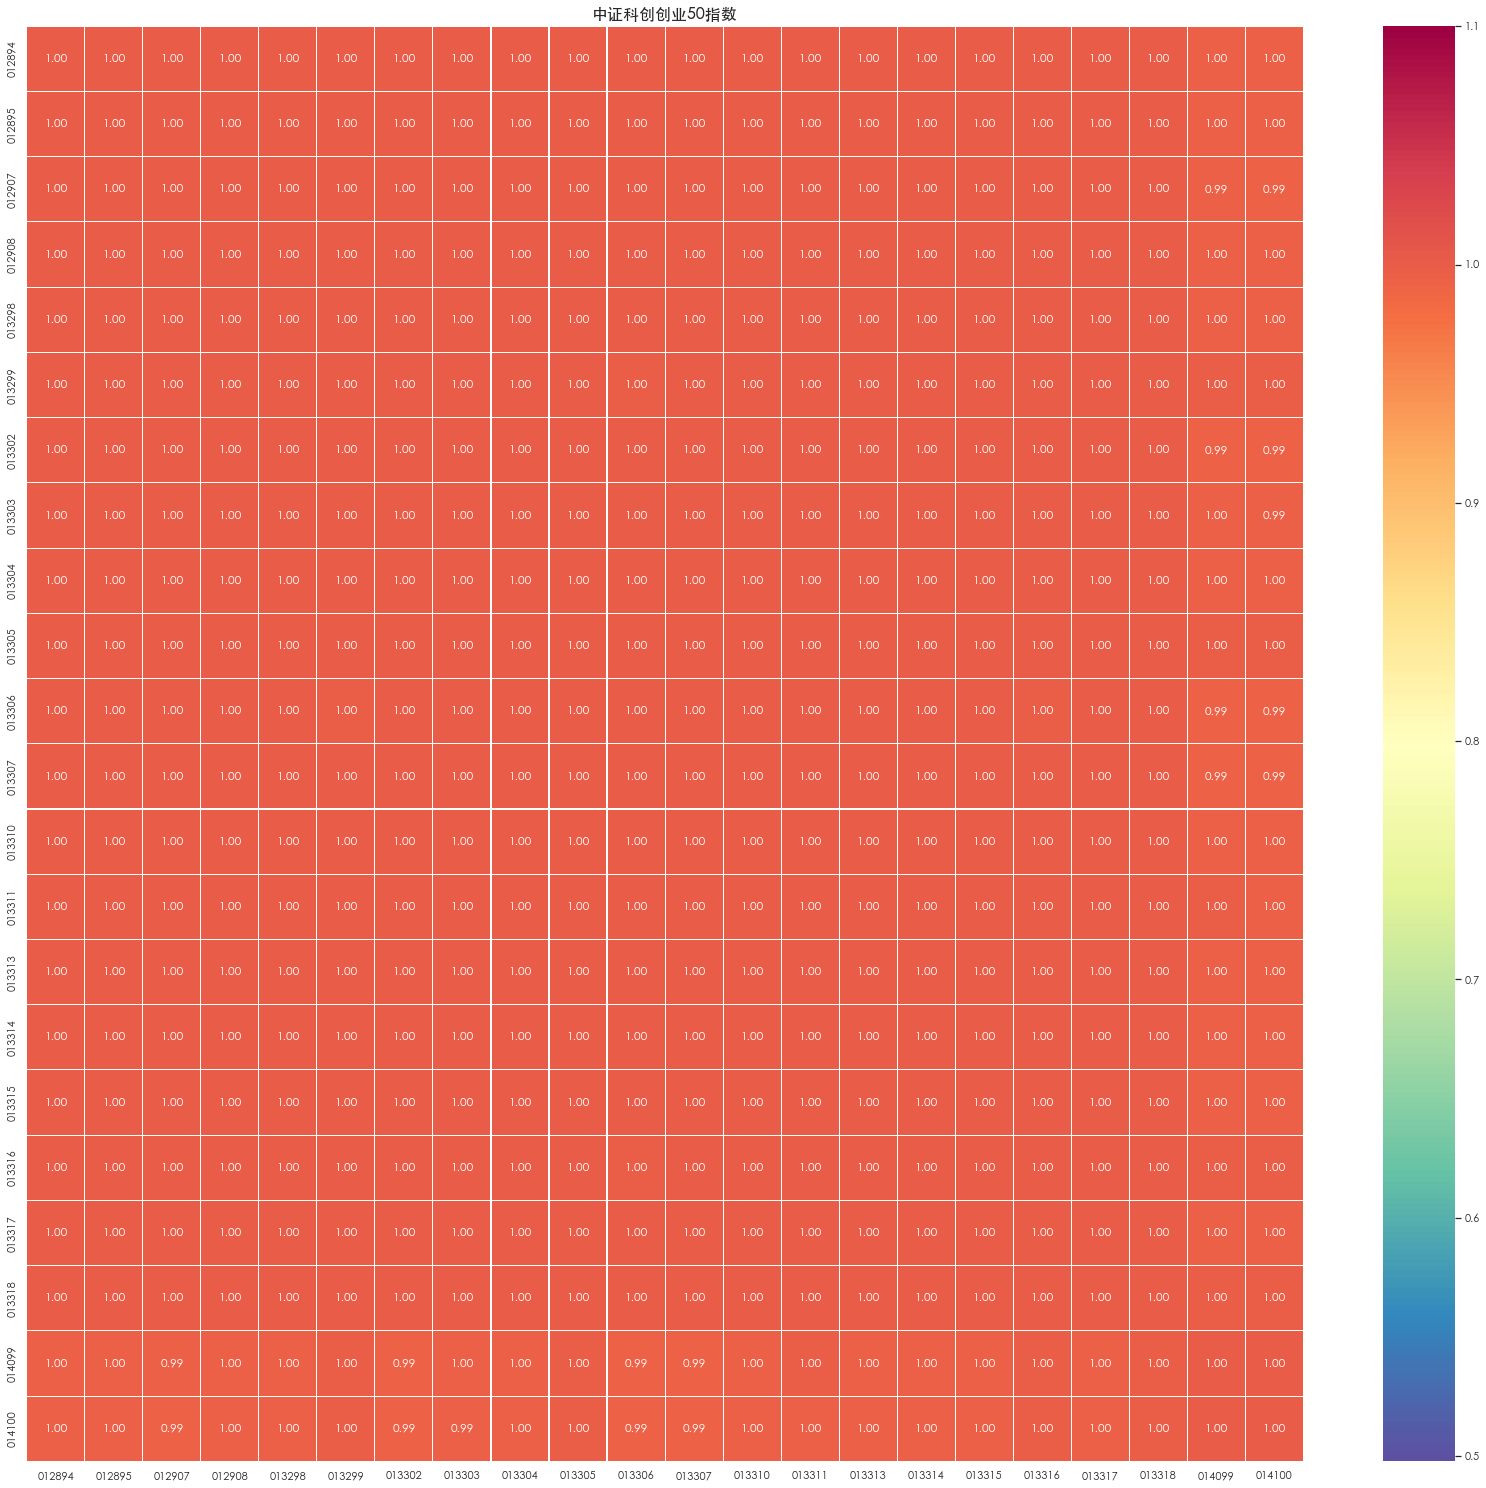

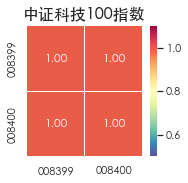

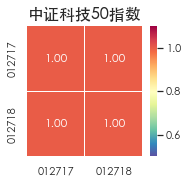

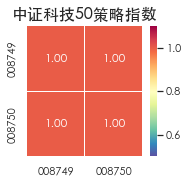

ignore group cause no valid data: 中证科技传媒通信150指数


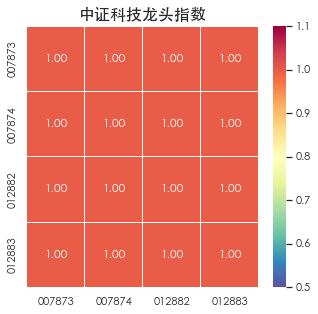

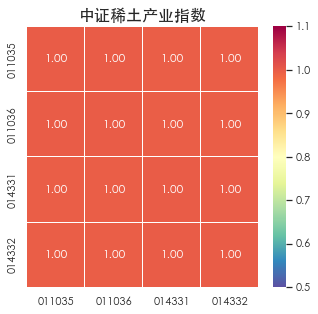

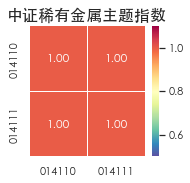

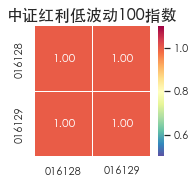

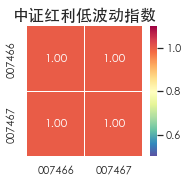

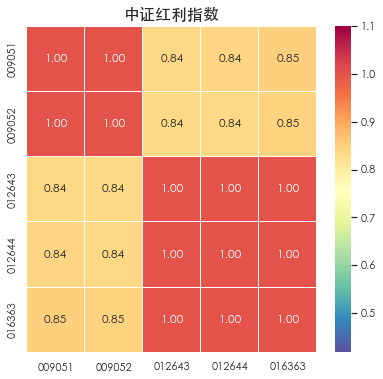

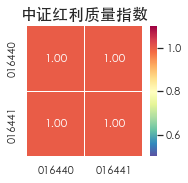

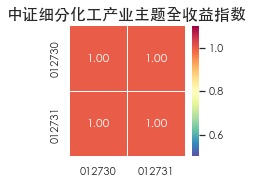

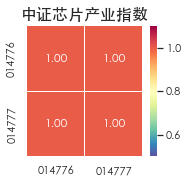

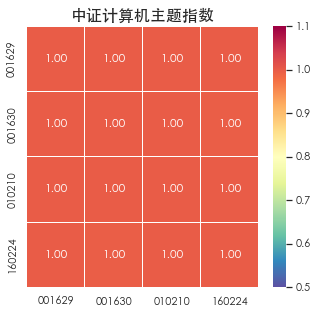

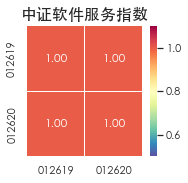

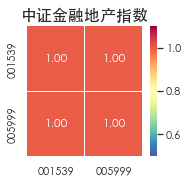

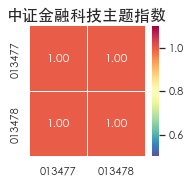

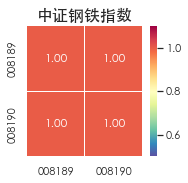

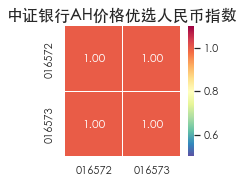

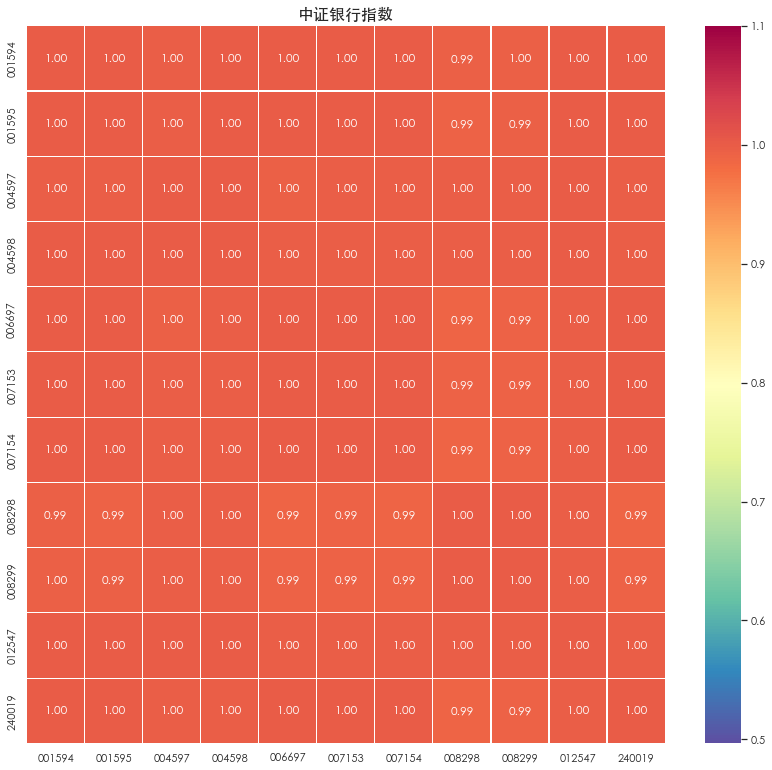

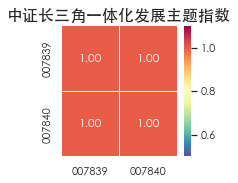

ignore group cause no valid data: 中证长三角领先指数
ignore group cause no valid data: 中证长江保护主题指数


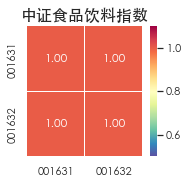

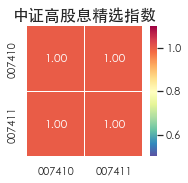

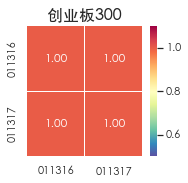

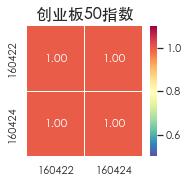

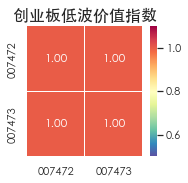

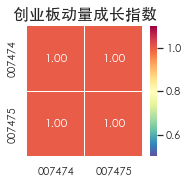

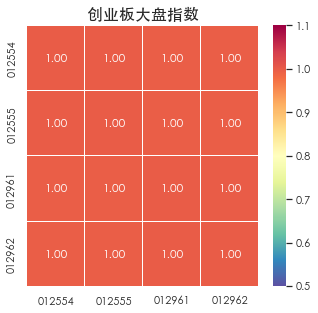

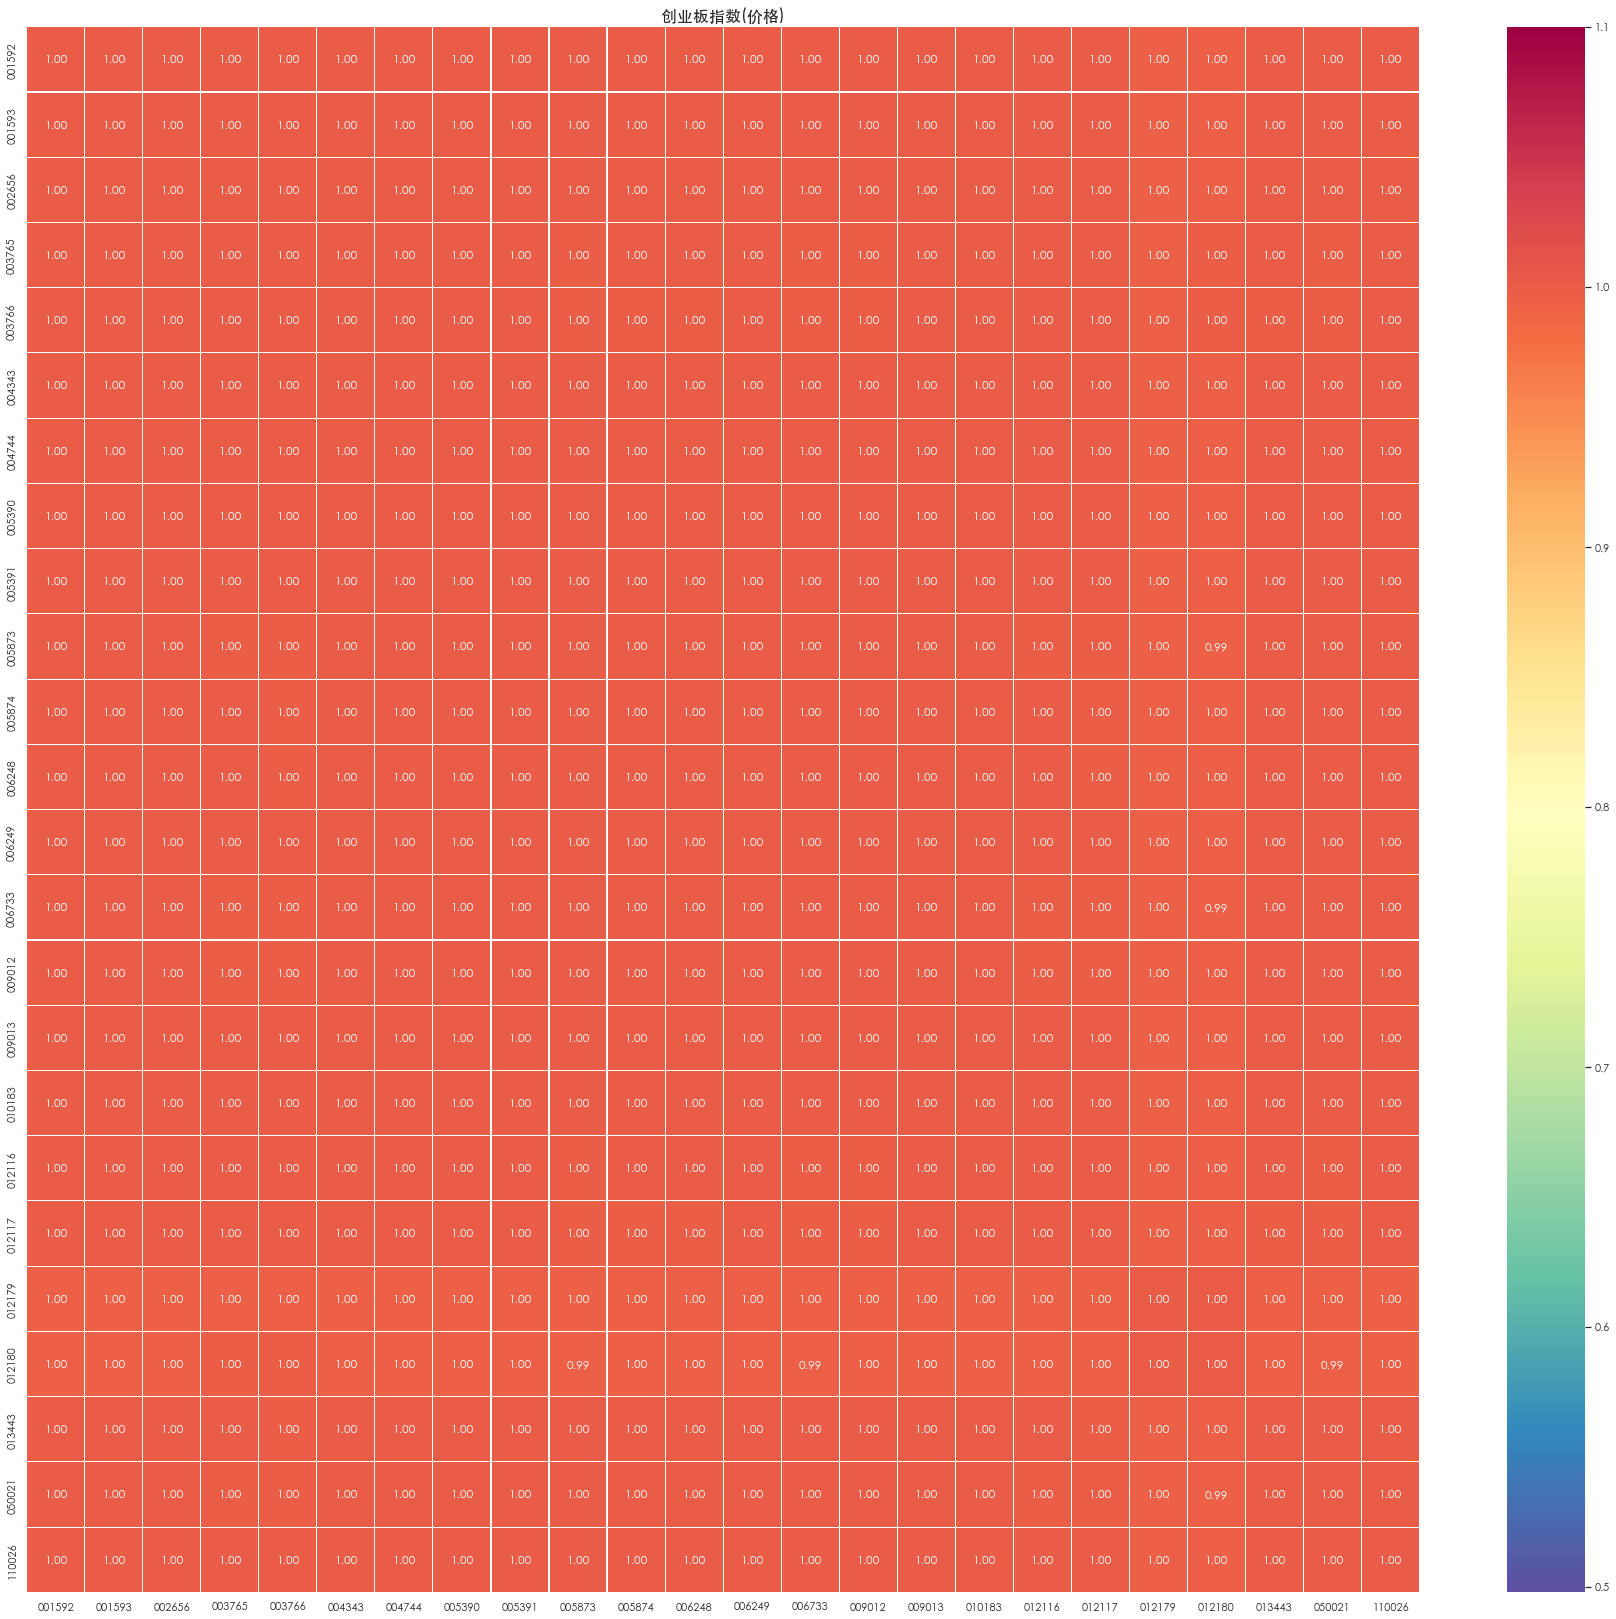

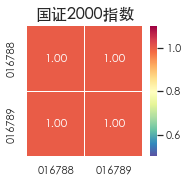

ignore group cause no valid data: 国证ESG300指数


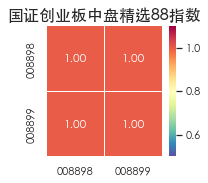

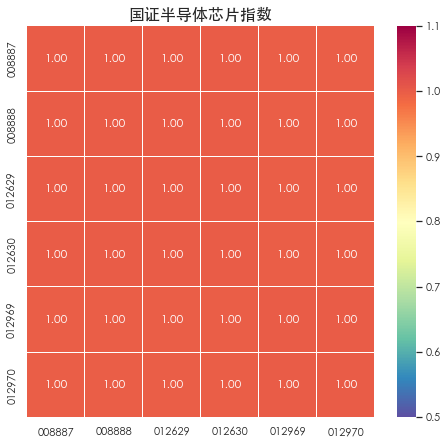

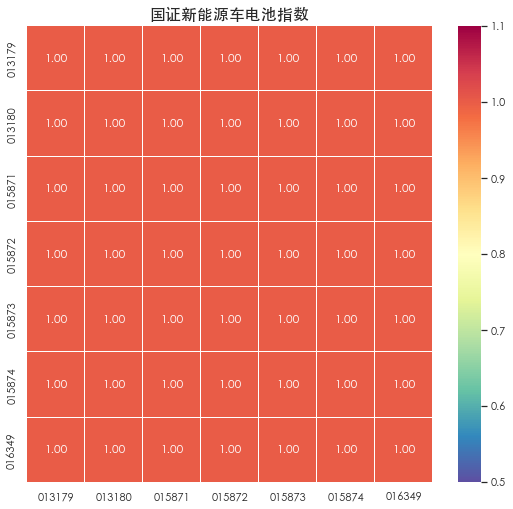

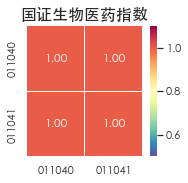

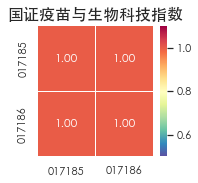

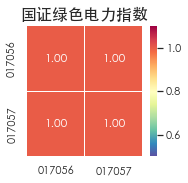

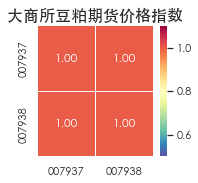

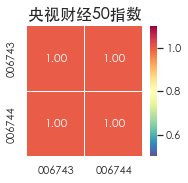

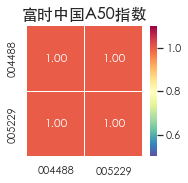

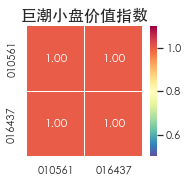

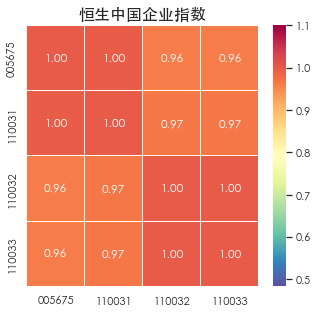

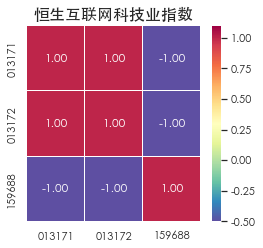

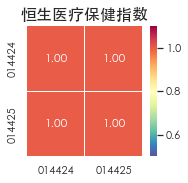

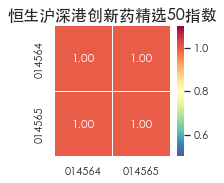

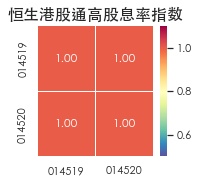

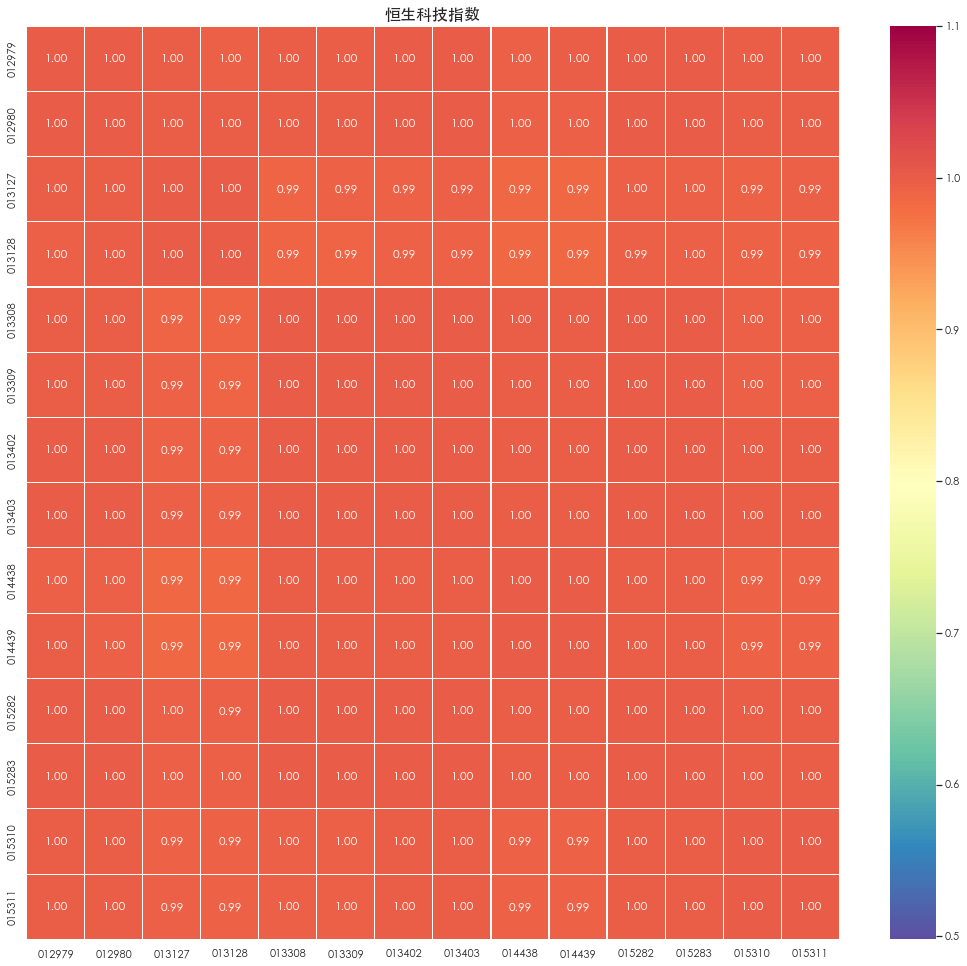

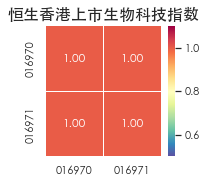

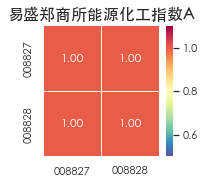

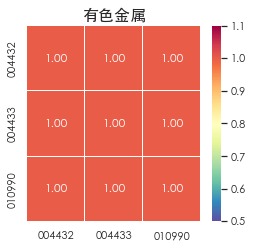

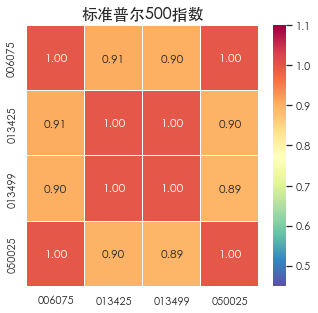

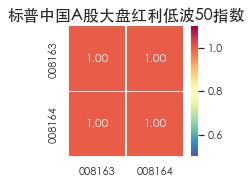

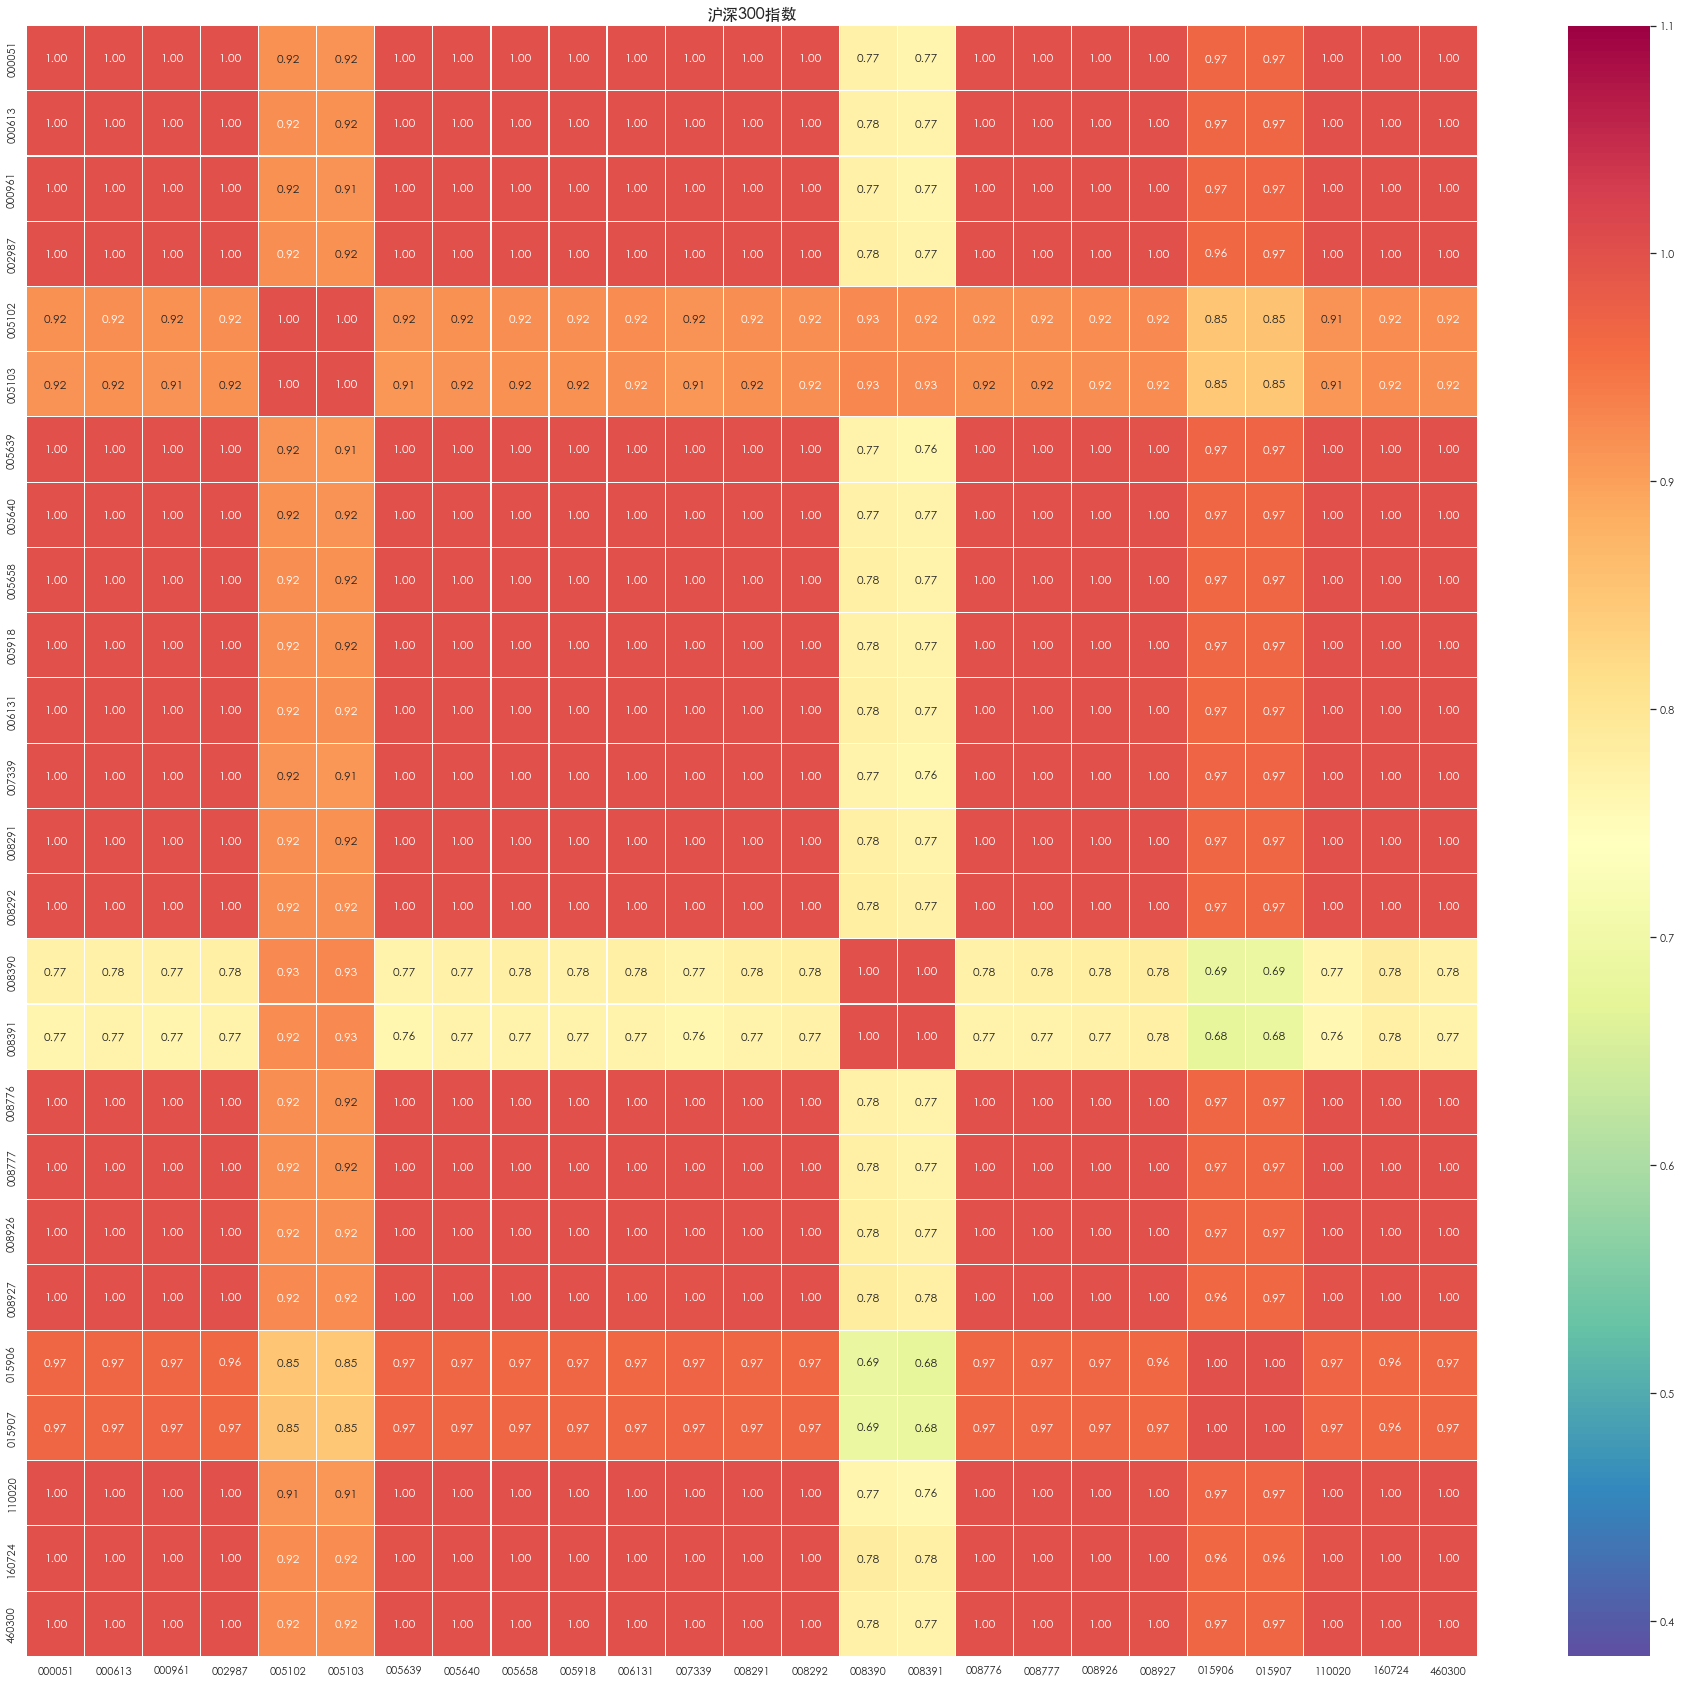

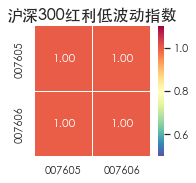

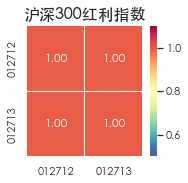

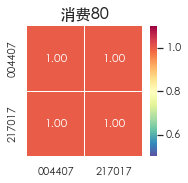

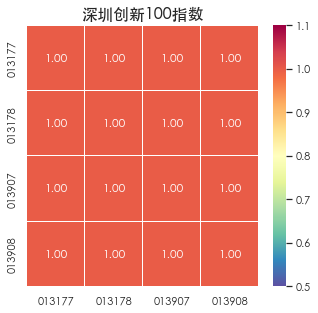

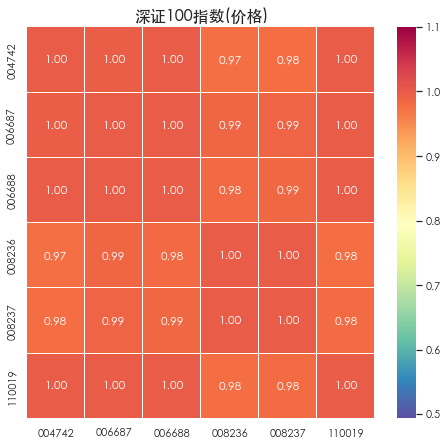

ignore group cause no valid data: 深证300价格


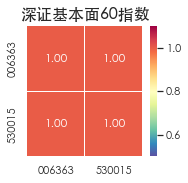

ignore group cause no valid data: 深证成份指数(价格)
ignore group cause no valid data: 深证成长40指数


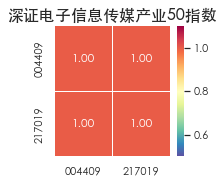

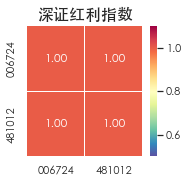

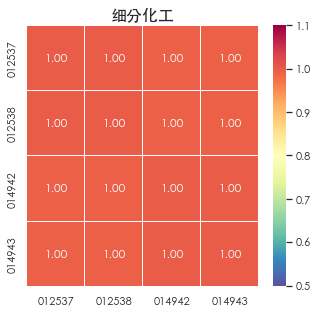

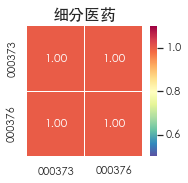

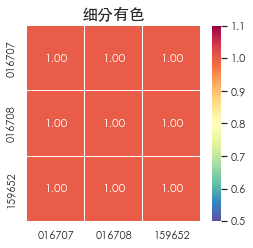

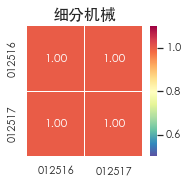

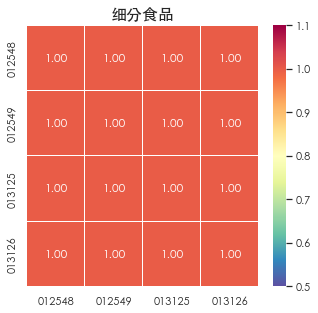

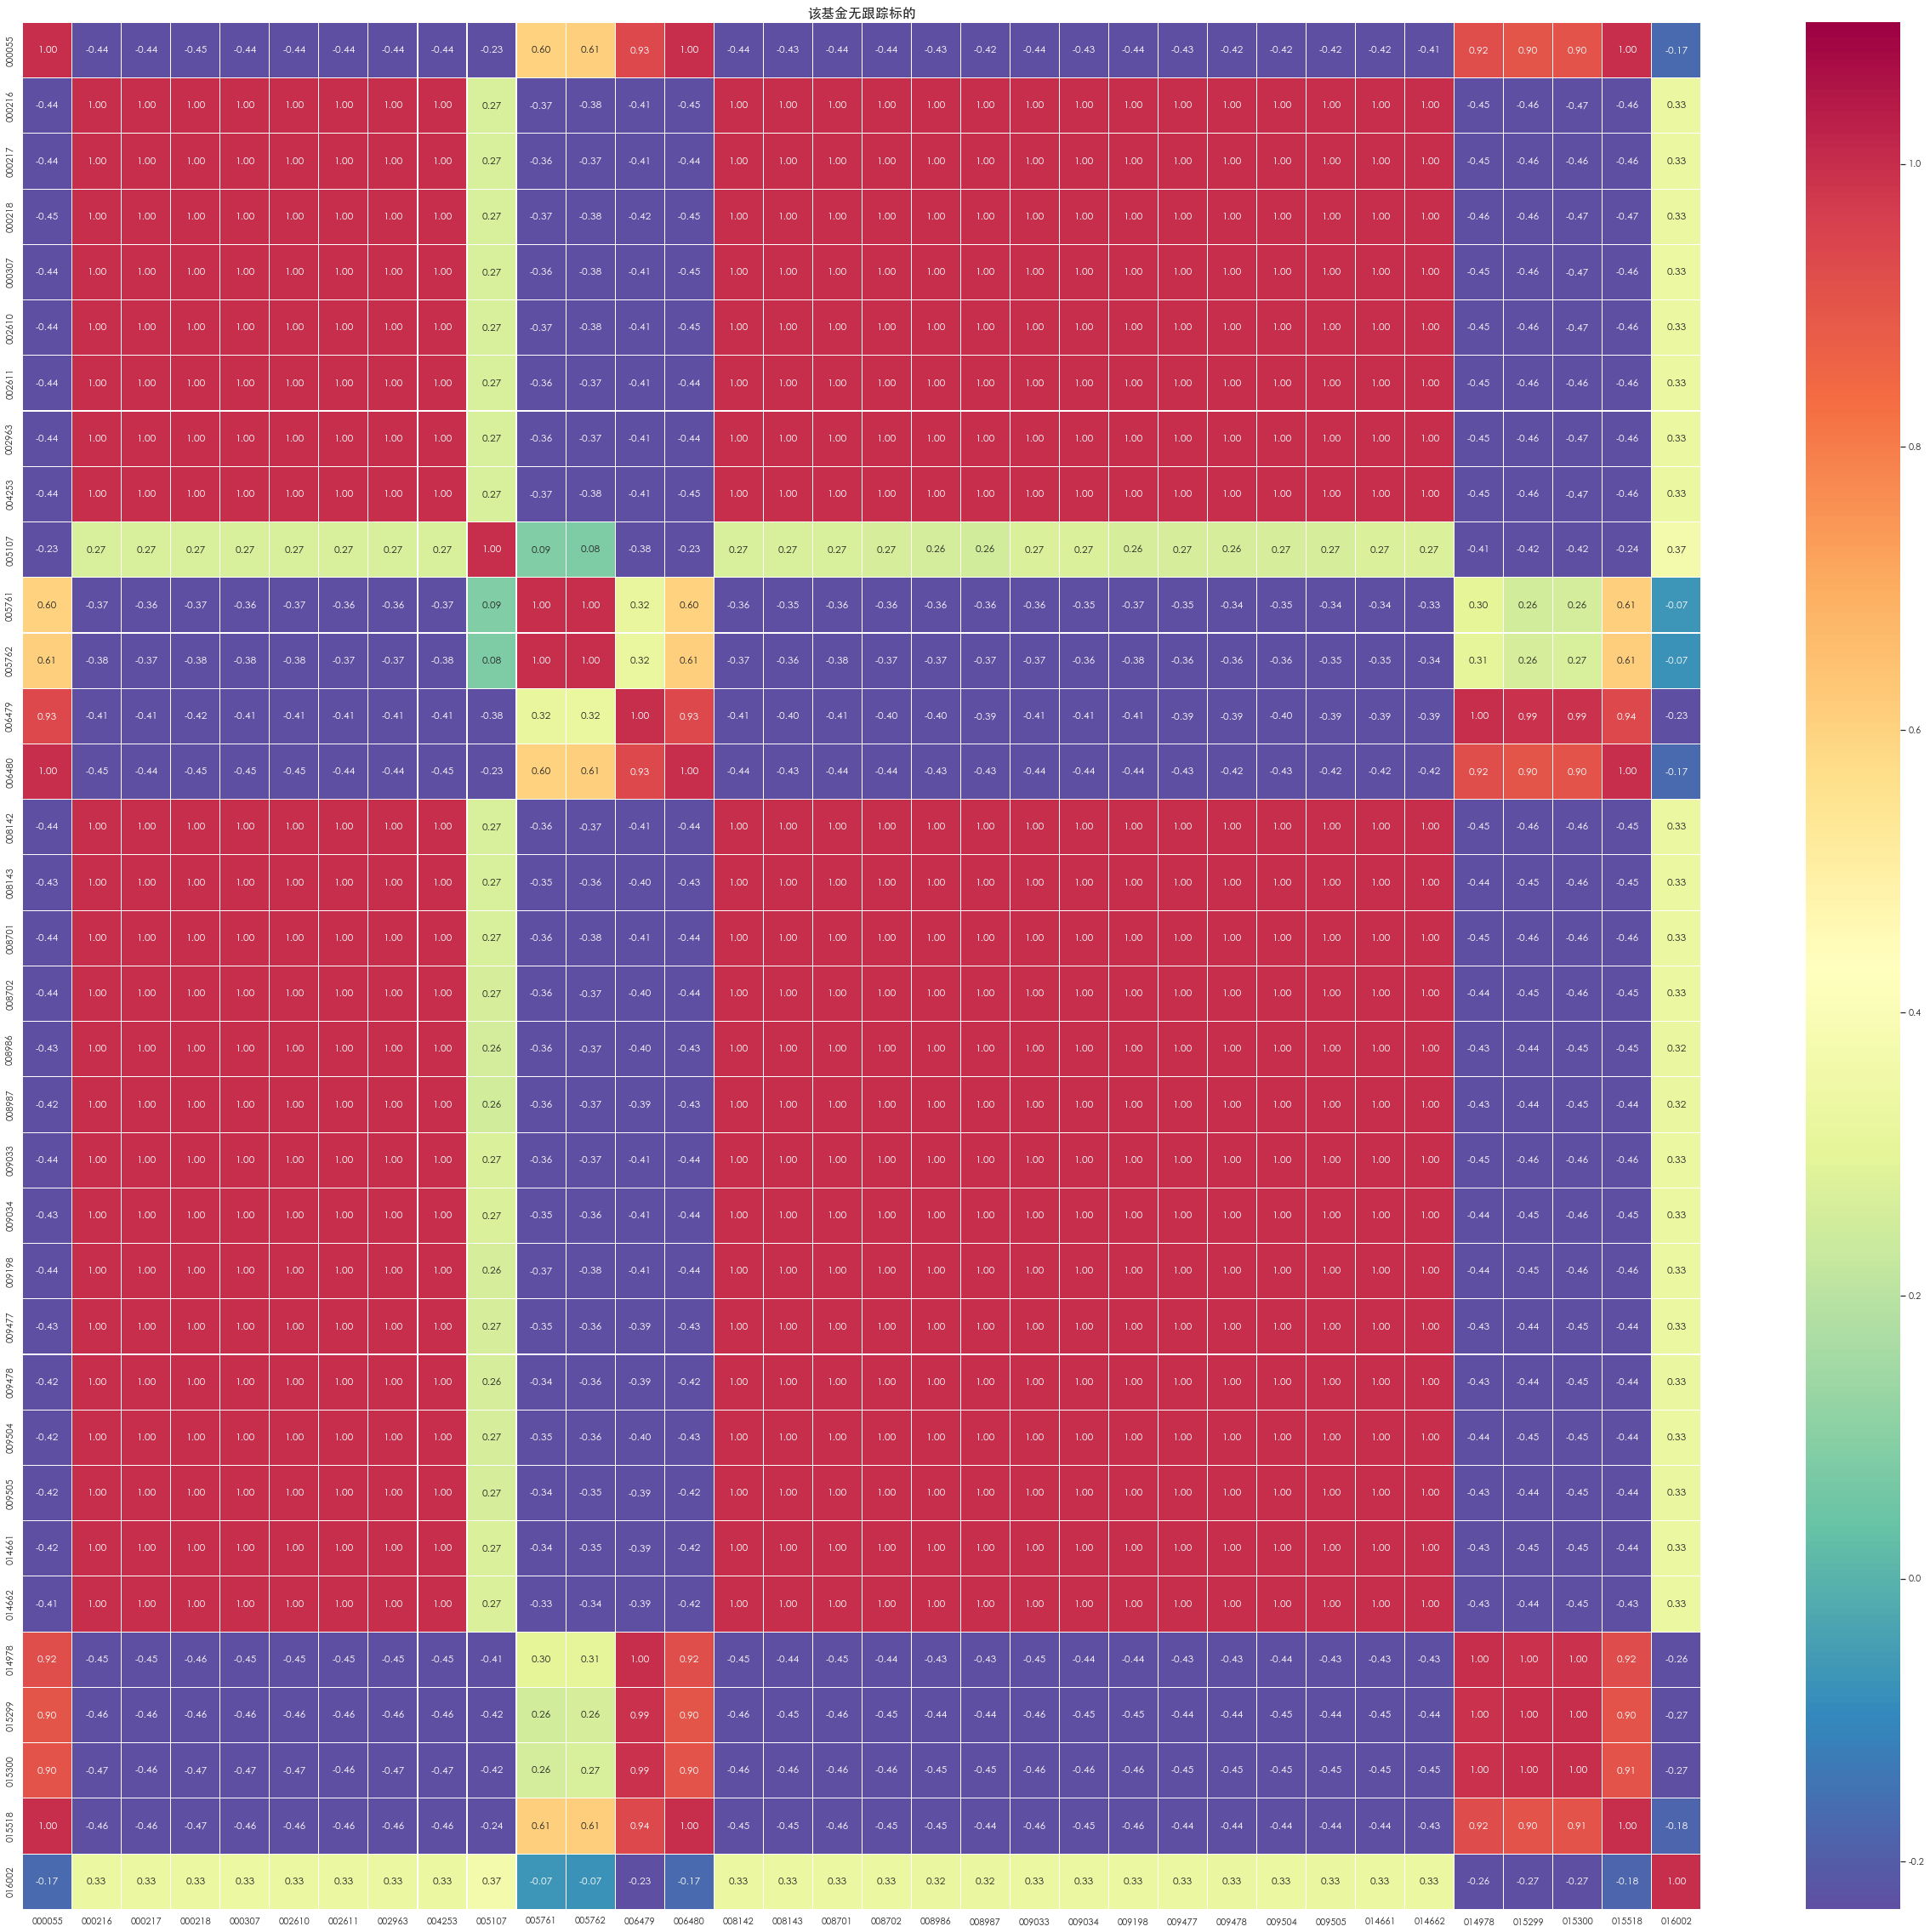

ignore group cause no valid data: 责任指数
ignore group cause no valid data: 非周期


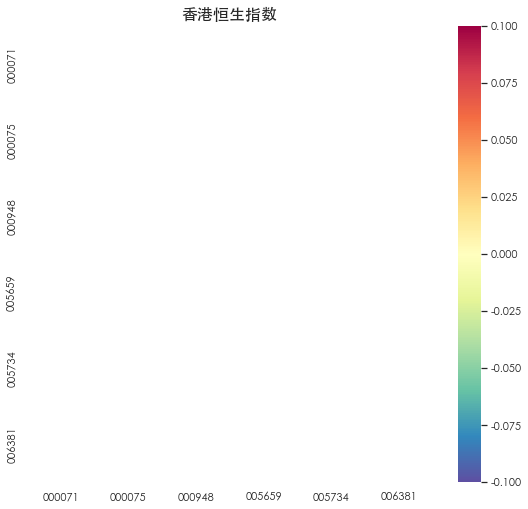

In [133]:
for gname, g in df.groupby('tracking'):
    
    data = None
    for _, row in g.iterrows():
        
        fname = f'.output.{row["code"]}.{row["created_at"]}_{today.strftime("%Y-%m-%d")}.csv'
        if not Path(fname).exists():
            continue
            
        d = pd.read_csv(fname)
        d[row['code']] = d['close']
        d = d[['datetime',row["code"]]]
        
        if data is not None:
            data = data.merge(d, how='inner', on='datetime')
        else:
            data = d
        
    if data is None or data.shape[1] < 3:
        print(f'ignore group cause no valid data: {gname}')
        continue
    
    del data['datetime']
    corr_plot(data, gname)
    